## Memuat Librarty & Dataset

In [21]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, ConfusionMatrixDisplay, auc
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

In [22]:
# Setup API Key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dan unzip dataset
!kaggle datasets download -d rakeshkapilavai/extrovert-vs-introvert-behavior-data
!unzip extrovert-vs-introvert-behavior-data.zip

df = pd.read_csv("personality_dataset.csv")  # Ganti dengan path lokal jika perlu

Dataset URL: https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data
License(s): CC-BY-SA-4.0
extrovert-vs-introvert-behavior-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  extrovert-vs-introvert-behavior-data.zip
replace personality_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: personality_dataset.csv  


## 1. Pendahuluan

###Domain dan Tujuan Proyek 🚀
Di dunia yang penuh interaksi sosial ini, memahami kepribadian seseorang—apakah mereka extrovert atau introvert—bisa sangat membantu dalam banyak bidang seperti psikologi, pemasaran, hingga pengembangan produk. Dataset ini dipilih karena menyediakan data nyata tentang perilaku sehari-hari yang terkait dengan kepribadian, dari waktu yang dihabiskan sendiri hingga bagaimana seseorang berinteraksi dengan lingkungan sosialnya.

Tujuan dari proyek ini adalah membuat model klasifikasi yang bisa memprediksi kepribadian seseorang berdasarkan kebiasaan dan pola sosial mereka. Dengan begitu, kita bisa lebih memahami karakter orang secara data-driven dan membuka peluang untuk aplikasi personalisasi, pengembangan diri, dan hubungan antar manusia yang lebih baik.

## 2. Data Understanding
Pada tahap ini, kita akan memahami data yang digunakan dalam proyek klasifikasi kepribadian. Dataset berisi beberapa fitur numerik dan kategorikal yang berhubungan dengan kebiasaan sosial dan aktivitas individu, serta target variabel yaitu tipe kepribadian.

### Deskripsi Dataset
Dataset ini terdiri dari 2,900 data dengan 8 fitur, yaitu 5 fitur numerik seperti lama waktu sendiri, kehadiran di acara sosial, frekuensi keluar rumah, ukuran lingkaran pertemanan, dan frekuensi posting di media sosial. Selain itu, terdapat 2 fitur kategorikal berupa ketakutan tampil di depan umum dan tingkat kelelahan setelah bersosialisasi. Target variabelnya adalah tipe kepribadian yang ingin diklasifikasikan.

### Cek Missing Values
Sebelum analisis, kita cek apakah terdapat data yang hilang (missing values) untuk memastikan kualitas dataset.

In [23]:
eda_df = df.copy()
print("Missing values tiap kolom:")
display(eda_df.isnull().sum())

Missing values tiap kolom:


,0
Time_spent_Alone,63
Stage_fear,73
Social_event_attendance,62
Going_outside,66
Drained_after_socializing,52
Friends_circle_size,77
Post_frequency,65
Personality,0


### Statistik Dasar
Kita dapat melihat statistik deskriptif dari fitur numerik untuk memahami rentang nilai, rata-rata, dan sebaran data.

In [24]:
eda_df.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,2837.000000,2838.000000,2834.000000,2823.000000,2835.000000
mean,4.505816,3.963354,3.000000,6.268863,3.564727
std,3.479192,2.903827,2.247327,4.289693,2.926582
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,3.000000,1.000000
50%,4.000000,3.000000,3.000000,5.000000,3.000000
75%,8.000000,6.000000,5.000000,10.000000,6.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


### Visualisasi Distribusi Fitur

#### Distribusi Target Variable
Melihat sebaran tipe kepribadian untuk memastikan dataset seimbang.

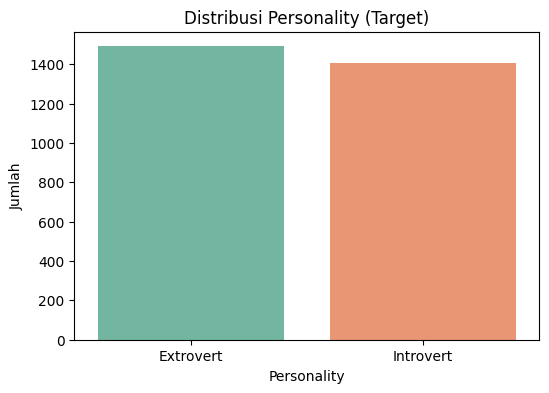

In [25]:
# Distribusi target variable
plt.figure(figsize=(6, 4))
sns.countplot(data=eda_df, x='Personality', palette='Set2')
plt.title("Distribusi Personality (Target)")
plt.ylabel("Jumlah")
plt.show()

#### Distribusi Fitur Numerik
Visualisasi histogram untuk fitur numerik menunjukkan sebaran dan distribusi nilai setiap fitur.

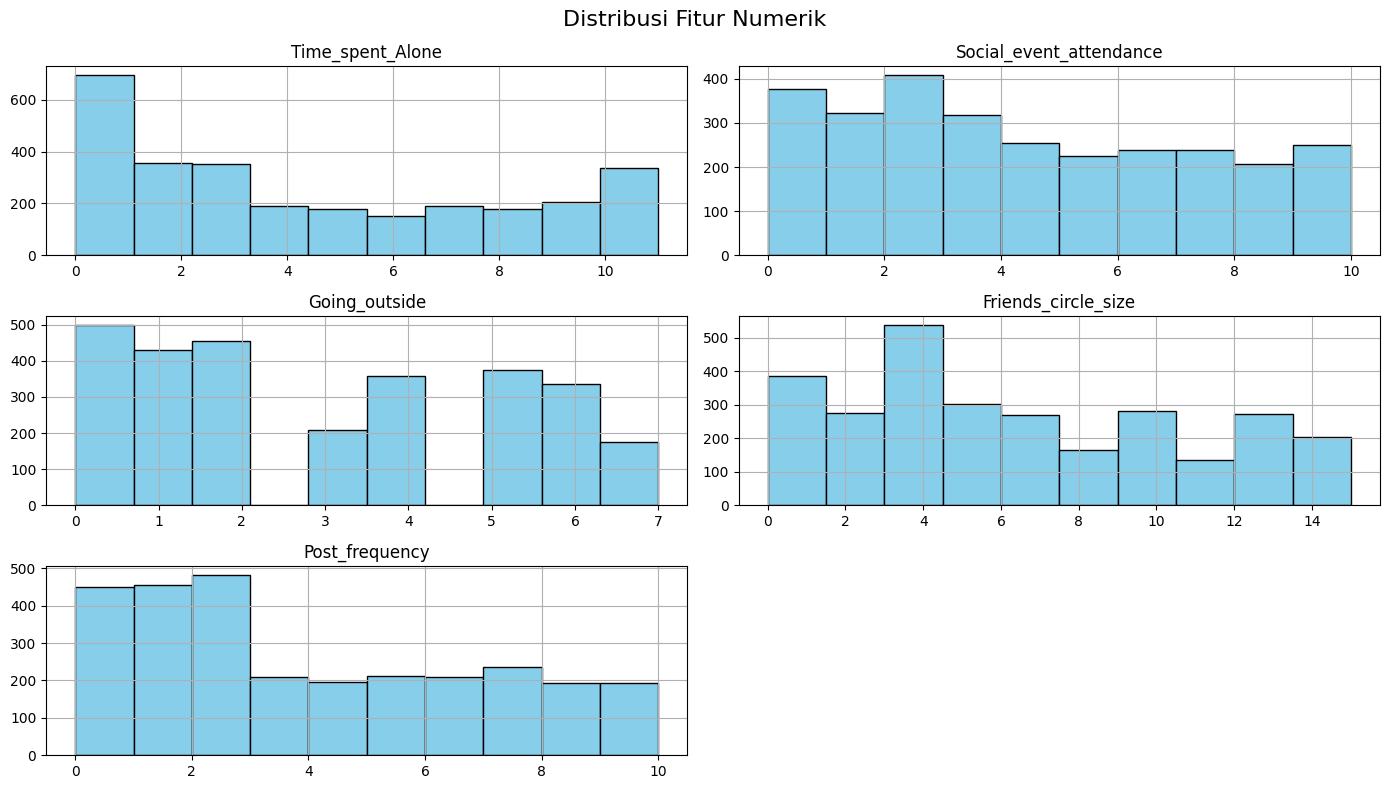

In [26]:
# Distribusi fitur numerik
numerik_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                'Friends_circle_size', 'Post_frequency']

eda_df[numerik_cols].hist(figsize=(14, 8), bins=10, color='skyblue', edgecolor='black')
plt.suptitle("Distribusi Fitur Numerik", fontsize=16)
plt.tight_layout()
plt.show()

#### Korelasi Antar Fitur Numerik
Heatmap korelasi membantu melihat hubungan antar fitur numerik untuk mengetahui fitur yang saling berkaitan.

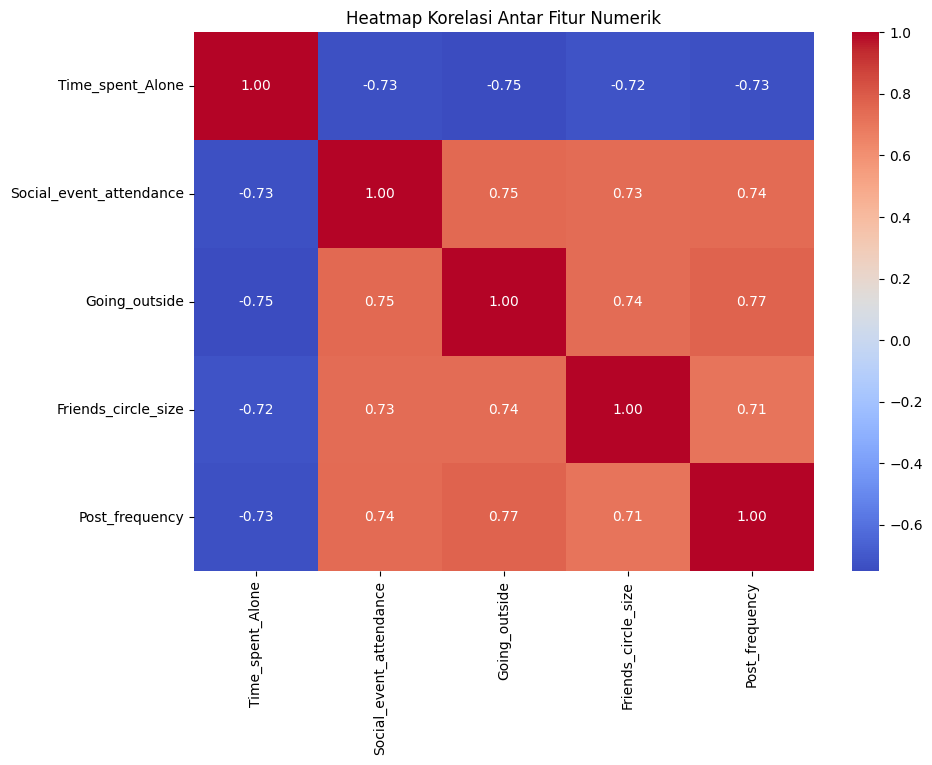

In [27]:
# Heatmap korelasi antar fitur numerik
plt.figure(figsize=(10, 7))
sns.heatmap(eda_df[numerik_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap Korelasi Antar Fitur Numerik")
plt.show()

#### Boxplot Fitur Numerik vs Personality
Boxplot memperlihatkan perbedaan distribusi fitur numerik berdasarkan tipe kepribadian.

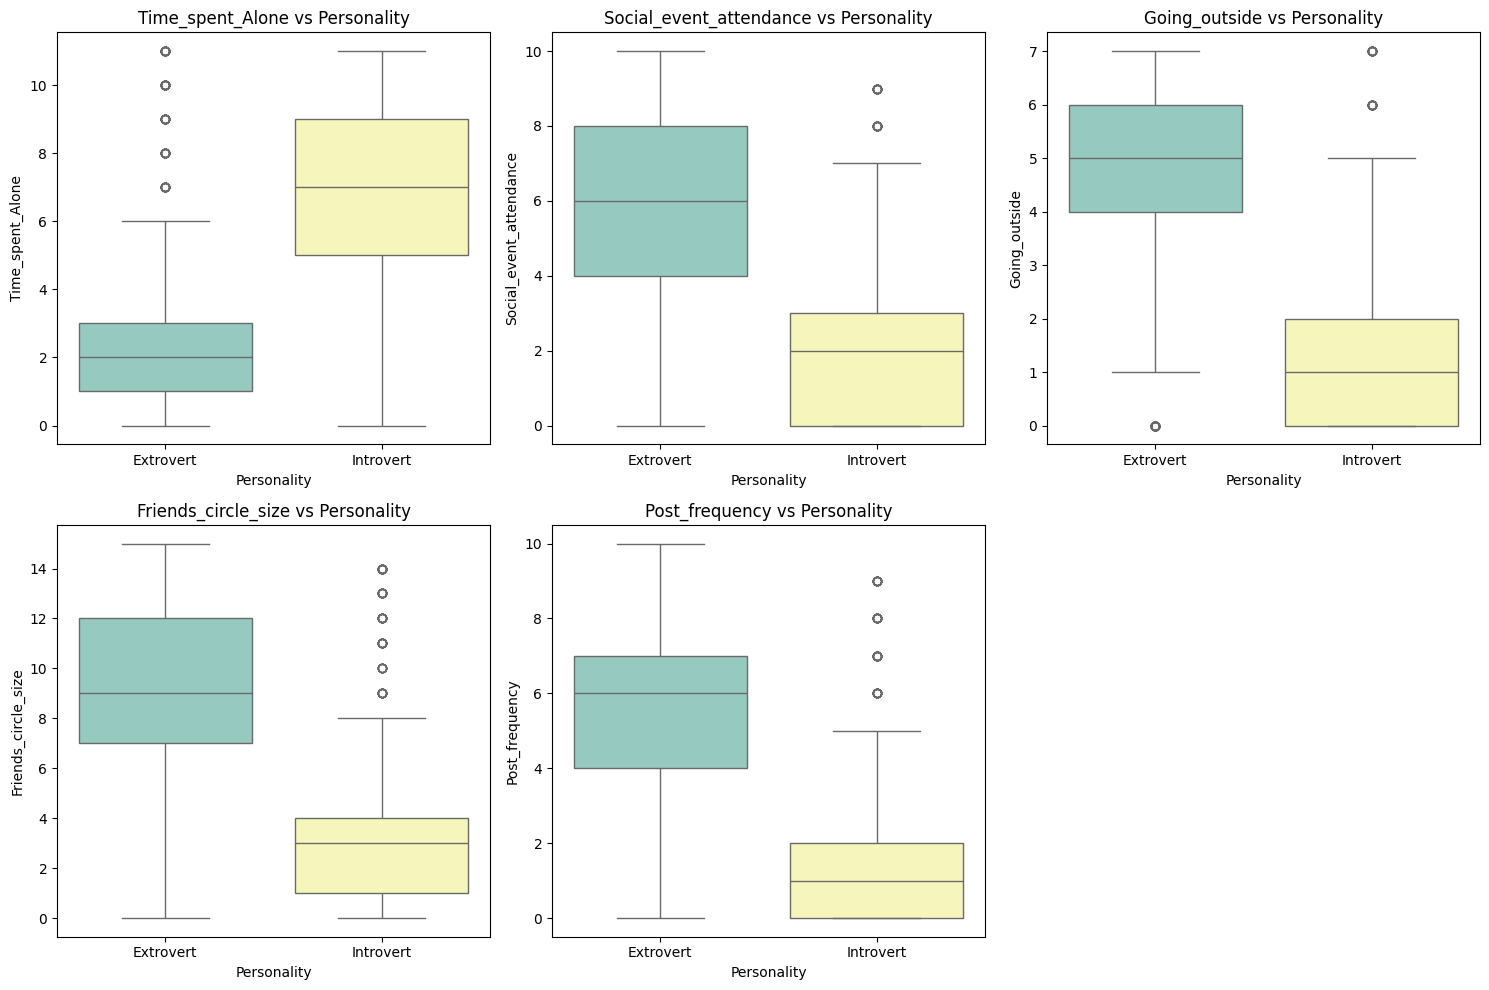

In [28]:
# Boxplot fitur numerik terhadap Personality
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerik_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=eda_df, x='Personality', y=col, palette='Set3')
    plt.title(f"{col} vs Personality")
plt.tight_layout()
plt.show()

#### Distribusi Fitur Kategorikal terhadap Personality
Visualisasi jumlah kategori pada fitur kategorikal berdasarkan tipe kepribadian.

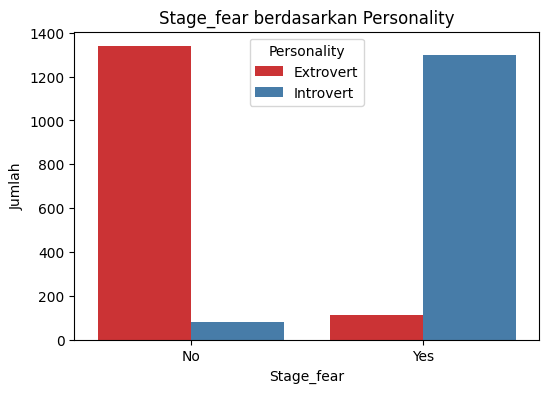

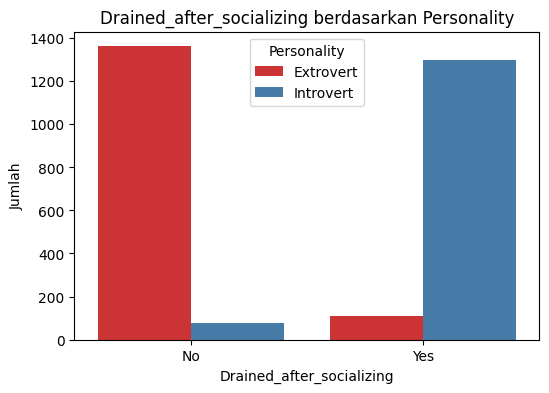

In [29]:
# Distribusi fitur kategorikal terhadap target
kategorik_cols = ['Stage_fear', 'Drained_after_socializing']

for col in kategorik_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=eda_df, x=col, hue='Personality', palette='Set1')
    plt.title(f"{col} berdasarkan Personality")
    plt.ylabel("Jumlah")
    plt.show()

## 3. Data Preparation
Pada tahap ini, kita melakukan persiapan data agar siap digunakan dalam pemodelan, dimulai dari penanganan missing values hingga transformasi data.

### Cek Missing Value
Pertama, kita cek apakah terdapat nilai yang hilang dalam dataset asli.

In [30]:
# Cek missing values pada dataset asli
print("Jumlah missing values tiap kolom:")
display(df.isnull().sum())

Jumlah missing values tiap kolom:


,0
Time_spent_Alone,63
Stage_fear,73
Social_event_attendance,62
Going_outside,66
Drained_after_socializing,52
Friends_circle_size,77
Post_frequency,65
Personality,0


### Penanganan Missing Values
Untuk mengisi data yang hilang, kita gunakan metode yang sesuai dengan tipe data:
* Kolom numerik diisi dengan median karena lebih tahan terhadap outlier dibandingkan rata-rata.
* Kolom kategorikal diisi dengan modus (nilai yang paling sering muncul).

In [31]:
# Salin data asli untuk preparation
prep_df = df.copy()

# Kolom numerik → isi dengan median (lebih robust dibanding mean)
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
            'Friends_circle_size', 'Post_frequency']
for col in num_cols:
    prep_df[col].fillna(prep_df[col].median(), inplace=True)

# Kolom kategorikal → isi dengan modus (nilai terbanyak)
cat_cols = ['Stage_fear', 'Drained_after_socializing', 'Personality']
for col in cat_cols:
    prep_df[col].fillna(prep_df[col].mode()[0], inplace=True)

# Cek ulang missing values setelah imputasi
print("Cek ulang missing values setelah imputasi:")
display(prep_df.isnull().sum())

Cek ulang missing values setelah imputasi:


,0
Time_spent_Alone,0
Stage_fear,0
Social_event_attendance,0
Going_outside,0
Drained_after_socializing,0
Friends_circle_size,0
Post_frequency,0
Personality,0


### Label Encoding
Karena algoritma pembelajaran mesin memerlukan data numerik, fitur kategorikal dikonversi ke angka menggunakan Label Encoding.

In [32]:
# Label Encoding pada kolom kategorikal
label_cols = ['Stage_fear', 'Drained_after_socializing', 'Personality']
label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    prep_df[col] = le.fit_transform(prep_df[col])
    label_encoders[col] = le

### Pisahkan Fitur dan Target
Fitur disimpan di variabel features, sedangkan target (label kepribadian) disimpan di target.

In [33]:
# Pisahkan fitur dan target
features = prep_df.drop(columns='Personality')
target = prep_df['Personality']

### Imputasi dan Scaling
Imputasi ulang fitur dengan metode mean untuk fitur numerik dan fitur hasil encoding, lalu lakukan scaling menggunakan StandardScaler agar fitur memiliki skala yang sama.

In [34]:
# Imputasi fitur numerik hasil encoding dan lainnya dengan mean
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Scaling fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_imputed)

### Konversi dan Split Data
Konversi data yang sudah diskalakan ke dalam DataFrame agar lebih mudah dikelola, lalu pisahkan data menjadi data latih dan data uji dengan perbandingan 80:20.

In [35]:
# Konversi hasil scaling ke DataFrame untuk kemudahan visualisasi
X_scaled_df = pd.DataFrame(X_scaled, columns=features.columns)

# Train/test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, target, test_size=0.2, random_state=42
)


## 4. Modeling
Pada tahap ini, kita membangun model klasifikasi untuk memprediksi kepribadian berdasarkan fitur-fitur yang tersedia. Dua algoritma yang digunakan adalah:
* Logistic Regression
* Random Forest Classifier

### Definisikan Model
Kedua model didefinisikan terlebih dahulu dengan random_state=42 agar hasilnya dapat direproduksi.

In [36]:
# Definisikan model
logreg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)

### Training Model
Model dilatih menggunakan data latih (X_train, y_train).

In [37]:
# Training model
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Prediksi pada Data Uji
Model yang sudah dilatih digunakan untuk melakukan prediksi pada data uji (X_test).

In [38]:
# Prediksi di test set
y_pred_logreg = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)

## 5. Evaluasi Model
Untuk mengukur performa model klasifikasi yang telah dilatih, digunakan beberapa metrik evaluasi berikut:
* Classification Report (Precision, Recall, F1-score, Accuracy)
* Confusion Matrix
* ROC Curve dan AUC
* Feature Importance (khusus Random Forest)

### Fungsi Evaluasi

In [39]:
# Fungsi plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot ROC Curve dan hitung AUC
def plot_roc_auc(model, X_test, y_test, title):
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{title} (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc='lower right')
    plt.show()

### Evaluasi Logistic Regression

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       302
           1       0.91      0.92      0.92       278

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



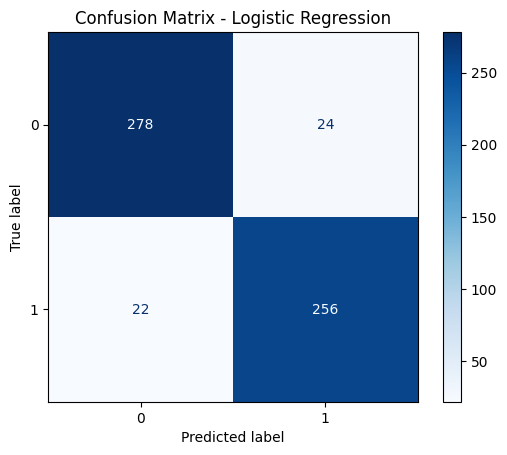

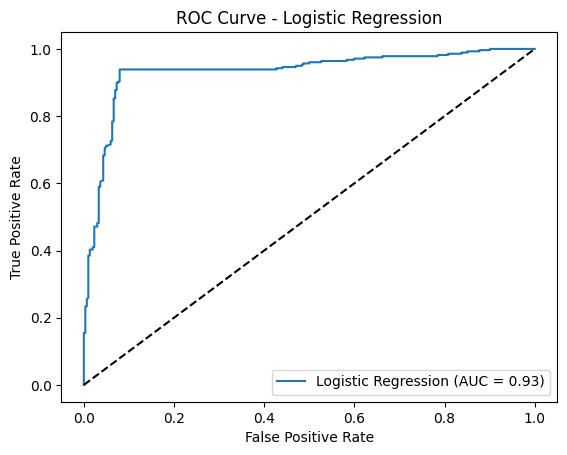

In [40]:
# Evaluasi Logistic Regression
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_logreg))
plot_confusion_matrix(y_test, y_pred_logreg, 'Confusion Matrix - Logistic Regression')
plot_roc_auc(logreg, X_test, y_test, 'Logistic Regression')

### Evaluasi Random Forest


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       302
           1       0.91      0.92      0.92       278

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



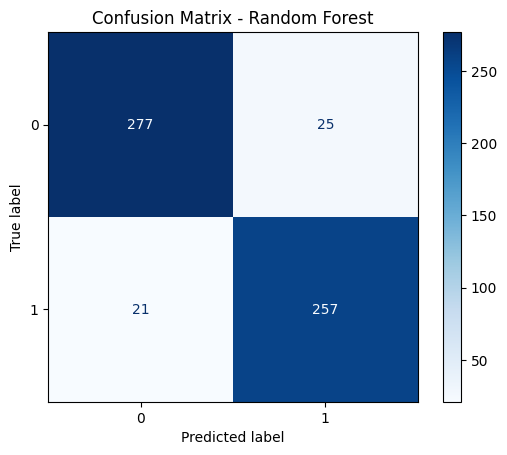

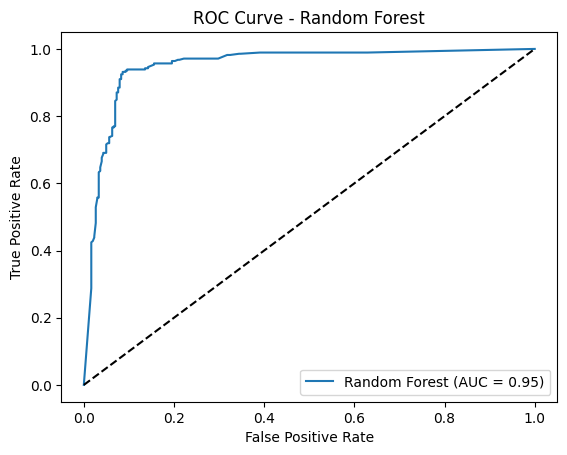

In [41]:
# Evaluasi Random Forest
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
plot_confusion_matrix(y_test, y_pred_rf, 'Confusion Matrix - Random Forest')
plot_roc_auc(rf, X_test, y_test, 'Random Forest')

### Feature Importance (Random Forest)
Visualisasi fitur yang paling berpengaruh terhadap prediksi model:

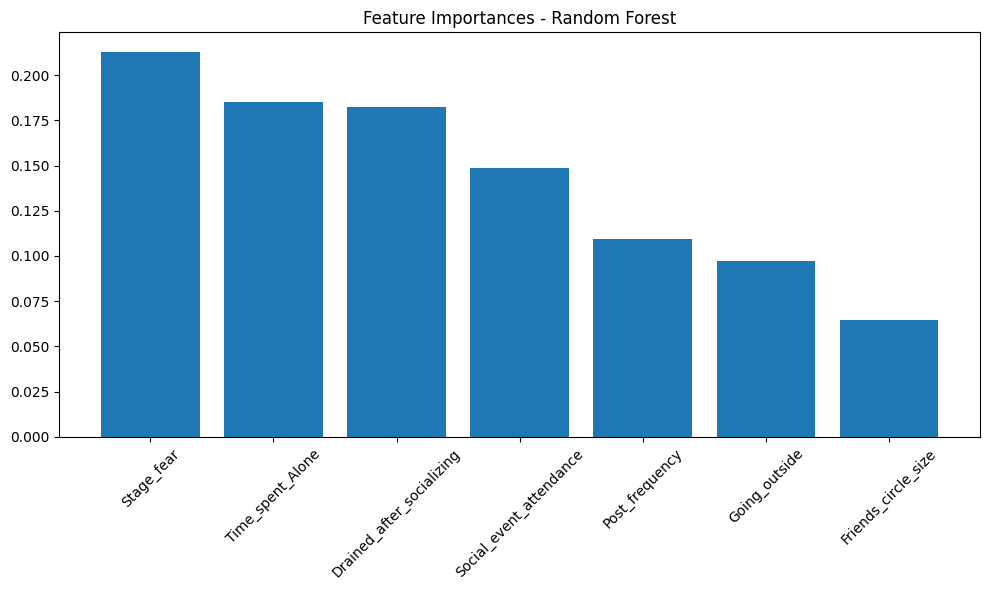

In [43]:
# Feature Importance dari Random Forest
importances = rf.feature_importances_
features = X_scaled_df.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

## 6. Kesimpulan
# 📊 Kesimpulan Proyek Klasifikasi Personality

## 1. Distribusi Target (Personality)
- Dataset menunjukkan distribusi yang seimbang antara dua kelas personality (0 dan 1).
- Hal ini mendukung performa model karena tidak ada dominasi kelas tertentu yang signifikan.

## 2. Pembersihan dan Persiapan Data
- **Missing values**:
  - Fitur numerik ditangani dengan imputasi median.
  - Fitur kategorikal ditangani dengan modus (nilai terbanyak).
- **Encoding**:
  - Label Encoding digunakan untuk kolom kategorikal seperti `Stage_fear`, `Drained_after_socializing`, dan `Personality`.
- **Scaling**:
  - Fitur numerik diskalakan dengan `StandardScaler` untuk menyeragamkan skala data.
  
## 3. Modeling dan Evaluasi
Dua model digunakan:

### 🔹 Logistic Regression
- **Akurasi**: 92%
- **Precision / Recall / F1-score**:
  - Kelas 0: 0.93 / 0.92 / 0.92
  - Kelas 1: 0.91 / 0.92 / 0.92
- **ROC AUC**: Tinggi, menunjukkan model memiliki kemampuan klasifikasi yang sangat baik.

### 🔸 Random Forest Classifier
- **Akurasi**: 92%
- **Precision / Recall / F1-score**:
  - Kelas 0: 0.93 / 0.92 / 0.92
  - Kelas 1: 0.91 / 0.92 / 0.92
- **ROC AUC**: Tinggi, mirip dengan Logistic Regression.

## 4. Feature Importance (dari Random Forest)
Fitur yang paling berkontribusi terhadap prediksi personality:
- `Stage_fear`
- `Time_spent_alone`
- `Drained_after_socializing`

## ✅ Rekomendasi
- Kedua model cukup andal dan dapat digunakan untuk klasifikasi personality.
- Random Forest disarankan jika interpretabilitas (feature importance) dibutuhkan.
- Lanjutkan validasi model dengan **cross-validation** untuk menguji generalisasi model.
- Pertimbangkan menambahkan fitur baru (misalnya: tingkat stres, preferensi digital, dsb) untuk memperkuat akurasi prediksi.

---

📌 Proyek ini menunjukkan bahwa data perilaku sosial dapat digunakan secara efektif untuk mengklasifikasikan tipe kepribadian menggunakan pendekatan machine learning.
